# Nueva versión MaximaMacro.jl ()

Una sola macro con paréntesis y comandos maxima entrecomillados.

**Sesión de una sola celda**  

✅ Ventajas de esta versión:

Nunca se bloquea: Maxima se cierra con quit().

Cada celda es independiente: no hay estado compartido.

No requiere gestión manual de sesiones.

Ideal para notebooks, informes diarios, o scripts simples.

⚠️ Limitaciones (y por qué son aceptables)

No conserva variables entre celdas: si defines a: 5$ en una celda, no existe en la siguiente.

→ Esto es deseable en muchos casos (reproducibilidad por celda).

Ligeramente más lento: inicia Maxima cada vez.

→ Pero Maxima arranca rápido, y para uso interactivo es imperceptible.

🔄 ¿Cuándo usar la versión persistente?
Solo si necesitas definir funciones, variables o estados complejos que se reutilicen en múltiples celdas.

Pero para la mayoría de los casos (especialmente en reportes o cálculos aislados), la versión por celda es más segura y simple.

### Sesión solo para una celda

**Versión sin salir bien los créditos**

In [1]:
module MaximaMacro


export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw = String(read(proc.out))
            wait(proc)
            for line in split(raw, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end
        else
            # ✅ Usar --quiet en lugar de --very-quiet
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw = String(read(proc.out))
            wait(proc)

            # Parsear resultados
            results = Dict{Int, String}()
            for line in split(raw, '\n')
                s = strip(line)
                # Buscar (%oN) incluso si hay espacios
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    val = m.captures[2]
                    # Ignorar (%o1) false de display2d
                    if n == 1 && val == "false"
                        continue
                    end
                    results[n] = line
                end
            end

            # Reconstruir salida limpia
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                println("(%i$(i)) $(cmd_clean);")
                if haskey(results, i + 1)
                    fixed = replace(results[i + 1], "(%o$(i+1))" => "(%o$(i))", count=1)
                    println(fixed)
                end
            end
        end
    end
end

end

Main.MaximaMacro

In [2]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3
(%i2) float(sqrt(2));
(%o2) 1.414213562373095
(%i3) solve(x^2 = 4, x);
(%o3) [x = -2,x = 2]


In [ ]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%o2) x^3/3
(%i3) 
(%o3) 1.414213562373095
(%i4) 
(%o4) [x = -2,x = 2]
(%i5) 


**Versión saliendo bien los créditos**

In [ ]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            println("Maxima 5.46.0 https://maxima.sourceforge.io")
            println("using Lisp GNU Common Lisp (GCL) GCL 2.6.14")
            println("Distributed under the GNU Public License. See the file COPYING.")
            println("Dedicated to the memory of William Schelter.")
            println()
        end

        proc = open(`maxima --quiet`, "r+")
        write(proc.in, "display2d:false\$\n")
        for cmd in $(user_cmds)
            write(proc.in, cmd * "\n")
        end
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        results = Dict{Int, String}()
        for line in split(raw, '\n')
            s = strip(line)
            m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
            if m !== nothing
                n = parse(Int, m.captures[1])
                val = m.captures[2]
                # Incluir (%o1) solo si no es el "false" de display2d
                if n == 1 && val == "false"
                    continue
                end
                results[n] = line
            end
        end

        # Mostrar display2d como primer comando si se piden créditos
        if $(creditos)
            println("(%i1) display2d:false\$")
            println("(%o1) false")
            println()
            offset = 1
        else
            offset = 0
        end

        for (i, cmd) in enumerate($(user_cmds))
            idx = i + offset
            cmd_clean = rstrip(strip(cmd), [';', '\$'])
            terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
            println("(%i$(idx)) $(cmd_clean)$(terminator)")
            if haskey(results, i + 1)
                # Ajustar número de salida
                out_line = results[i + 1]
                out_line_fixed = replace(out_line, "(%o$(i+1))" => "(%o$(idx))", count=1)
                println(out_line_fixed)
            end
            println()  # 🔹 Línea en blanco después de cada bloque
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.

(%i1) display2d:false$
(%o1) false

(%i2) integrate(x^2, x);
(%o2) x^3/3

(%i3) float(sqrt(2));
(%o3) 1.414213562373095

(%i4) solve(x^2 = 4, x);
(%o4) [x = -2,x = 2]



In [ ]:
using .MaximaMacro
@maxima_session_cell(
    "load(qinf)",
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.



(%i1) display2d:false$
(%o1) false

(%i2) load(qinf);
(%o2) "/home/miguel/.maxima/qinf.mac"

(%i3) integrate(x^2, x);
(%o3) x^3/3

(%i4) float(sqrt(2));
(%o4) 1.414213562373095

(%i5) solve(x^2 = 4, x);
(%o5) [x = -2,x = 2]

(%i6) ket(1) + ket(2);
(%o6) matrix([3])



**Por defecto cargar qinf**

In [ ]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            println("Maxima 5.46.0 https://maxima.sourceforge.io")
            println("using Lisp GNU Common Lisp (GCL) GCL 2.6.14")
            println("Distributed under the GNU Public License. See the file COPYING.")
            println("Dedicated to the memory of William Schelter.")
            println()
        end

        # Comandos que SIEMPRE se envían a Maxima (silenciosos si creditos=false)
        proc = open(`maxima --quiet`, "r+")
        write(proc.in, "display2d:false\$\n")
        write(proc.in, "load(qinf)\$\n")
        for cmd in $(user_cmds)
            write(proc.in, cmd * "\n")
        end
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        # Parsear todas las salidas (%oN)
        results = Dict{Int, String}()
        for line in split(raw, '\n')
            s = strip(line)
            m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
            if m !== nothing
                n = parse(Int, m.captures[1])
                results[n] = line
            end
        end

        if $(creditos)
            # Mostrar TODO: display2d, load(qinf), y comandos del usuario
            output_lines = String[]

            # (%i1) display2d:false$
            push!(output_lines, "(%i1) display2d:false\$")
            push!(output_lines, haskey(results, 1) ? results[1] : "(%o1) false")
            push!(output_lines, "")

            # (%i2) load(qinf)$
            push!(output_lines, "(%i2) load(qinf)\$")
            push!(output_lines, haskey(results, 2) ? results[2] : "(%o2) false")
            push!(output_lines, "")

            # Comandos del usuario: empiezan en %i3
            for (i, cmd) in enumerate($(user_cmds))
                idx = 3 + i - 1
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                push!(output_lines, "(%i$(idx)) $(cmd_clean)$(terminator)")
                result_key = 3 + i - 1  # %o3, %o4, ...
                if haskey(results, result_key)
                    out_line = results[result_key]
                    out_line_fixed = replace(out_line, "(%o$(result_key))" => "(%o$(idx))", count=1)
                    push!(output_lines, out_line_fixed)
                end
                push!(output_lines, "")
            end

            for line in output_lines
                println(line)
            end

        else
            # Modo silencioso: omitir %i1 y %i2 (display2d y load(qinf))
            # Los comandos del usuario empiezan en %i1 visualmente
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = 3 + i - 1  # porque %o1 y %o2 ya usados
                if haskey(results, result_key)
                    out_line = results[result_key]
                    out_line_fixed = replace(out_line, "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(out_line_fixed)
                end
                println()  # línea en blanco
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_session_cell(
    "load(qinf)",
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.

(%i1) display2d:false$
(%o1) false

(%i2) load(qinf)$
(%o2) false

(%i3) load(qinf);
(%o3) "/home/miguel/.maxima/qinf.mac"

(%i4) integrate(x^2, x);
(%o4) x^3/3

(%i5) float(sqrt(2));
(%o5) 1.414213562373095

(%i6) solve(x^2 = 4, x);
(%o6) [x = -2,x = 2]

(%i7) ket(1) + ket(2);
(%o7) matrix([3])



In [ ]:
module MaximaMacro

export @maxima_session_cell

macro maxima_session_cell(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final (solo si es una asignación explícita)
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: usar Maxima sin --quiet para obtener cabecera real ──
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Imprimir toda la salida no vacía (incluye cabecera real y prompts)
            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: usar --quiet, ocultar setup, mostrar solo comandos del usuario ──
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los dos primeros comandos (%i1: display2d, %i2: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o3+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 2  # %o3, %o4, ...
                if haskey(results, result_key)
                    # Ajustar número de salida para que coincida con %iN visible
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_session_cell(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)", 
    "ket(1) + ket(2);",
    creditos=true
)

Maxima 5.46.0 https://maxima.sourceforge.io
using Lisp GNU Common Lisp (GCL) GCL 2.6.14 git tag Version_2_6_15pre7
Distributed under the GNU Public License. See the file COPYING.
Dedicated to the memory of William Schelter.
The function bug_report() provides bug reporting information.
(%i1) 
(%i2) 
(%i3) 
(%o3) x^3/3
(%i4) 
(%o4) 1.414213562373095
(%i5) 
(%o5) [x = -2,x = 2]
(%i6) 
(%o6) matrix([3])
(%i7) 


**Sin créditos cargando automáticamente display2d:false y qinf**

In [ ]:
module MaximaMacro

export @maxima_cell_session

macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: salida completa con cabecera real de Maxima ──
            proc = open(`maxima --disable-readline`, "r+")
            # Configurar salida 1D sin truncamiento:
            #   display2d:false → desactiva salida 2D (ASCII art)
            #   linel:32767     → límite de caracteres por línea (máximo permitido en Maxima)
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: ocultar configuración inicial y qinf ──
            proc = open(`maxima --quiet`, "r+")
            # Misma configuración, pero silenciosa
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los primeros 3 comandos (%i1: display2d, %i2: linel, %i3: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o4+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3  # %o4, %o5, ...
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2, x)",
    "float(sqrt(2))",
    "solve(x^2 = 4, x)",
    "ket(1) + ket(2)"
)

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(sqrt(2));
(%o2) 1.414213562373095

(%i3) solve(x^2 = 4, x);
(%o3) [x = -2,x = 2]

(%i4) ket(1) + ket(2);
(%o4) matrix([3])



**Incluyendo funciones de evaluación de un comando maxima desde Julia**

Inclue qinf

In [ ]:
module MaximaMacro

export @maxima_cell_session, maxima_eval

"""
    maxima_eval(cmd::String)::String

Envía un único comando a Maxima y devuelve su resultado como cadena en formato 1D.
El comando se evalúa en un entorno limpio con:
  - display2d:false
  - linel:32767
  - qinf cargado (si está disponible)

Ejemplo:
    maxima_eval("integrate(x^2, x)")  →  "x^3/3"
    maxima_eval("float(%pi)")         →  "3.141592653589793"
"""
function maxima_eval(cmd::String)::String
    # Asegurar terminación
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    # Ejecutar Maxima en modo silencioso
    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)

    raw = String(read(proc.out))
    wait(proc)

    # Buscar la primera salida (%oN) después de los comandos iniciales
    # (%o1: display2d, %o2: linel, %o3: load(qinf), %o4: resultado del usuario)
    results = String[]
    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)  # El resultado del usuario es %o4
        if m !== nothing
            push!(results, m.captures[1])
        end
    end

    if length(results) == 0
        return ""  # sin resultado
    else
        return results[1]
    end
end

# ----------------------------
# Macro: @maxima_cell_session
# ----------------------------

macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar comandos del usuario
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            # ── Modo créditos: salida completa con cabecera real de Maxima ──
            proc = open(`maxima --disable-readline`, "r+")
            # Configurar salida 1D sin truncamiento:
            #   display2d:false → desactiva salida 2D (ASCII art)
            #   linel:32767     → límite de caracteres por línea (máximo permitido en Maxima)
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            # ── Modo limpio: ocultar configuración inicial y qinf ──
            proc = open(`maxima --quiet`, "r+")
            # Misma configuración, pero silenciosa
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            # Parsear salidas (%oN)
            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            # Los primeros 3 comandos (%i1: display2d, %i2: linel, %i3: load) están ocultos
            # Los comandos del usuario empiezan visualmente en %i1, pero son %o4+
            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3  # %o4, %o5, ...
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()  # línea en blanco entre bloques
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro

# Resultado simbólico (cadena)
expr = maxima_eval("integrate(x^2, x)")
println(expr)  # → "x^3/3"

# Resultado numérico (cadena)
num_str = maxima_eval("float(sqrt(2))")
println(num_str)  # → "1.414213562373095"

# Convertir a número en Julia
num = parse(Float64, num_str)
println(num + 1)  # → 2.414213562373095

# Con qinf (si está instalado)
ket_result = maxima_eval("ket(0) + ket(1)")
println(ket_result)  # → "matrix([1],[1])"  (ejemplo)

x^3/3
1.414213562373095
2.414213562373095
matrix([1])


# Como tratar la devolución de gráficos de maxima a Julia en Jupyter

https://chat.qwen.ai/c/d3b26030-6946-457f-a448-3a8a3c8b7972

$sudo apt install gnuplot

Esta versión no me gusta, quiero que se aplique de manera automática

In [ ]:
module MaximaMacro

using Base.Filesystem: mktemp
using Base: UUID
using Markdown

export @maxima_cell_session, maxima_eval, maxima_plot

# -------------------------------------------------
# maxima_eval: evalúa un comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)

    raw = String(read(proc.out))
    wait(proc)

    # El resultado del usuario es %o4
    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# maxima_plot: genera y muestra un gráfico en Jupyter
# -------------------------------------------------
"""
    maxima_plot(plot_cmd::String; format="png", width=600, height=400)

Ejecuta un comando de gráfico de Maxima (como `plot2d(...)`) y muestra el resultado en Jupyter.

Ejemplo:
    maxima_plot("plot2d(sin(x), [x, -%pi, %pi])")
"""
function maxima_plot(plot_cmd::String; format="png", width=600, height=400)
    if !occursin("plot2d", plot_cmd) && !occursin("plot3d", plot_cmd)
        error("El comando debe contener plot2d o plot3d")
    end

    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = tempname() * "." * format
    option_name = format * "_file"  # → "png_file", "svg_file", etc.

    try
        maxima_cmd = """
        display2d:false\$
        linel:32767\$
        load("qinf")\$
        $(cmd_clean), [$option_name, "$(tmpfile)"]\$
        """

        proc = open(`maxima --quiet`, "r+")
        write(proc.in, maxima_cmd)
        close(proc.in)
        raw = String(read(proc.out))
        wait(proc)

        if !isfile(tmpfile)
            @warn "Maxima no generó el archivo de gráfico. ¿Está Gnuplot instalado?"
            println("Salida de Maxima:\n", raw)
            return nothing
        end

        if format == "png"
            display("image/png", read(tmpfile))
        elseif format == "svg"
            display("image/svg+xml", read(tmpfile, String))
        else
            @info "Formato '$format' no soportado para visualización directa."
            @info "Archivo guardado temporalmente en: $tmpfile"
        end

    finally
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end

# -------------------------------------------------
# Macro: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    quote
        if $(creditos)
            proc = open(`maxima --disable-readline`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            for line in split(raw_output, '\n')
                s = strip(line)
                if s != ""
                    println(line)
                end
            end

        else
            proc = open(`maxima --quiet`, "r+")
            write(proc.in, "display2d:false\$\n")
            write(proc.in, "linel:32767\$\n")
            write(proc.in, "load(\"qinf\")\$\n")
            for cmd in $(user_cmds)
                write(proc.in, cmd * "\n")
            end
            close(proc.in)
            raw_output = String(read(proc.out))
            wait(proc)

            results = Dict{Int, String}()
            for line in split(raw_output, '\n')
                s = strip(line)
                m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                if m !== nothing
                    n = parse(Int, m.captures[1])
                    results[n] = line
                end
            end

            for (i, cmd) in enumerate($(user_cmds))
                cmd_clean = rstrip(strip(cmd), [';', '\$'])
                terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                println("(%i$(i)) $(cmd_clean)$(terminator)")
                result_key = i + 3
                if haskey(results, result_key)
                    fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                    println(fixed_line)
                end
                println()
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
module MaximaMacro

using Base: tempname
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# Función auxiliar: ¿es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# maxima_eval (sin cambios esenciales)
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "load(\"qinf\")\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# maxima_plot_to_jupyter (interna)
# -------------------------------------------------
function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = "maxima_plot_temp.$format"
    macfile = tempname() * ".mac"

    # Asegurar limpieza previa
    isfile(tmpfile) && rm(tmpfile)

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    load("qinf")\$
    gnuplot_term: "$(format) size 800,600"\$
    gnuplot_out_file: "$(tmpfile)"\$
    $(cmd_clean)\$
    gnuplot_out_file: false\$
    """

    write(macfile, mac_content)

    env = copy(ENV)
    env["GNUTERM"] = format

    try
        run(setenv(`maxima --quiet --batch=$macfile`, env))

        if !isfile(tmpfile) || filesize(tmpfile) == 0
            println("❌ No se generó el gráfico.")
            return false
        end

        # Leer y mostrar
        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        # Guardar copia permanente
        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        # NO borrar tmpfile aquí — Jupyter ya lo leyó
    end

    # Borrar tmpfile después de display
    isfile(tmpfile) && rm(tmpfile, force=true)
end

# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Verificar si hay comandos gráficos
    plot_indices = Int[]
    for (i, cmd) in enumerate(user_cmds)
        if is_plot_command(cmd)
            push!(plot_indices, i)
        end
    end

    if !isempty(plot_indices)
        # Modo gráfico: procesar cada comando gráfico
        quote
            # Si hay modo créditos, advertir que no se aplica a gráficos
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora para comandos gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    println("🎨 Generando gráfico $(i): $(cmd)")
                    _maxima_plot_to_jupyter(cmd)
                    println()  # línea en blanco
                else
                    # Comando no gráfico: usar maxima_eval y mostrar
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # Modo texto habitual (sin gráficos)
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end

            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

In [ ]:
using .MaximaMacro
@maxima_cell_session(
    "integrate(x^2,x)", 
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

(%i1) integrate(x^2,x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

🎨 Generando gráfico 3: plot2d(sin(x), [x, -%pi, %pi]);

(%i1) batch("/tmp/jl_O9u3YpUt4h.mac")

read and interpret /tmp/jl_O9u3YpUt4h.mac
(%i2) kill(all)
(%i1) display2d:false
(%i2) linel:32767
(%i3) load("qinf")
(%i4) gnuplot_term:"png size 800,600"
(%i5) gnuplot_out_file:"maxima_plot_temp.png"
(%i6) plot2d(sin(x),[x,-%pi,%pi])
(%i7) gnuplot_out_file:false
(%o8) "/tmp/jl_O9u3YpUt4h.mac"
❌ No se generó el gráfico.



base64 binary data: iVBORw0KGgo=
base64 binary data: AAAADUlIRFIAAAKAAAAB4AgCAAAAurNLswAAAAlwSFlzAAAOxAAADsQBlSsOGwAAIABJREFUeJzt3X1wVNX9x/GzIUBigZplGh0a8xMVSTOMT4mJpYxgYkeCDDqjiYzFEasEq06mBdoRhiYEa2t9qmMllICK1BImMYUZA8moCQat7WAyA1idmGJKUdOIo8mkSFpjsr8/Vte42Yeb3XvvOfec92v8A9bN5rB7737v53vOvdcXCAQEAABwV4rsAQAAYCIKMAAAElCAAQCQgAIMAIAEFGAAACSgAAMAIAEFGAAACSjAAABIQAEGAEACCjAAABJQgAEAkIACDACABBRgAAAkoAADACABBRgAAAkowAAASEABBgBAAgowAAASUIABAJCAAgwAgASpsgfgIJ/PJ3sIAABNBAIBe19Q5wIsLLxfPp/P9vfUW3gHeAcMfwcM/+cL3gFr74ATiY4WNAAAElCAAQCQgAIMAIAEOrf+mdgAANjCiYJCAgYAQAIKMGA6TtgDpKAAAwAgAQUYMB1LJQApvFeAW1tbX3zxRdmjAAAgKd4rwBs2bDh06JDsUQD6YA4YkMIzBfjDDz/cunXrwoULDx8+LHssAAAkyzPXgj527Nju3buFEGlpabLHAmiFOWBACs8U4JKSkpKSEiHEnDlzZI8FAIBkeaYFDcAhzAEDUlCAAQCQgAIMmI45YEAKz8wBJ2Zsb41vGQCKGz8bwPeWRE7PzmiegANjyB4LoCjmgN1XXS18vgj/BQLh/0V8GtzhdAXRvAADgDoaGkRZWeRCG/xvvIhPoxLrgQIMmI7+kAuCkbehQZSWikBAbNqU1KuFVeLqansGCZd5rwD/4x//eOSRR2SPAgAsCZbeYL2srxelpXa+eFglhrd4rwADsBdzwE4I6zYnGXlj27SJMuxJFGAAsJO93eYJoQx7CwUYMB1zwHZ

https://chatgpt.com/c/68fe5e02-9f08-8325-a1ab-077b4e15832f

Para ver si tengo que cargar cosas para graficar en Julia

https://chat.qwen.ai/c/d3b26030-6946-457f-a448-3a8a3c8b7972



In [ ]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# Genera y muestra gráfico en Jupyter + guarda en ./plots/
# -------------------------------------------------

function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = joinpath(pwd(), "maxima_plot_temp.$format")
    macfile = tempname() * ".mac"

    isfile(tmpfile) && rm(tmpfile)

    # Reconstruir comando con opciones integradas
    if endswith(cmd_clean, ")")
        plot_with_opts = cmd_clean[1:end-1] *
                         ", [gnuplot_term, $format], " *
                         "[gnuplot_out_file, \"$(tmpfile)\"])"
    else
        plot_with_opts = cmd_clean
    end

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    ignore(load("qinf"))\$
    gnuplot_pipes: true\$
    $plot_with_opts\$
    """

    write(macfile, mac_content)

    try
        # ✅ Suprimir salida de Maxima
        run(pipeline(`maxima --quiet --batch=$macfile`, stderr=devnull, stdout=devnull))

        # Espera activa
        max_wait = 2.0
        check_interval = 0.1
        elapsed = 0.0
        file_ready = false
        while elapsed < max_wait
            if isfile(tmpfile) && filesize(tmpfile) > 0
                file_ready = true
                break
            end
            sleep(check_interval)
            elapsed += check_interval
        end

        if !file_ready
            println("❌ No se generó el gráfico.")
            return false
        end

        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end
# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo híbrido: procesar comandos uno a uno ──
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    println("🎨 Generando gráfico $(i): $(cmd)")
                    $(Symbol("_maxima_plot_to_jupyter"))(cmd)
                    println()
                else
                    # Comando no gráfico: evaluar y mostrar
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # ── Modo texto puro ──
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end
            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

🎨 Generando gráfico 1: 
    plot2d(sin(x), [x, -%pi, %pi]);



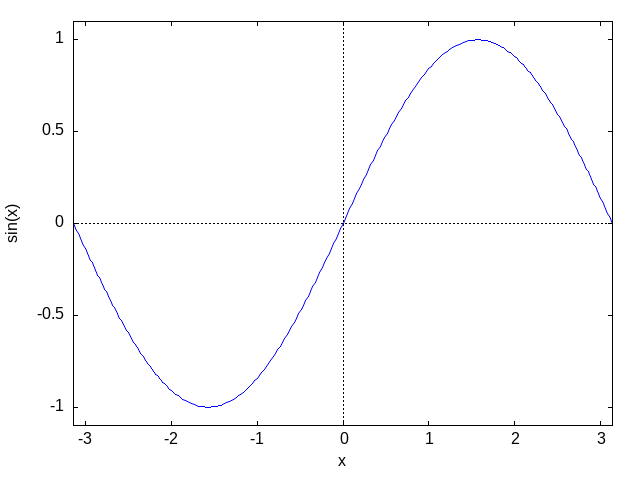

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_10_29T21_15_06_211.png



In [ ]:
using .MaximaMacro
@maxima_cell_session "
    plot2d(sin(x), [x, -%pi, %pi]);
"

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

🎨 Generando gráfico 3: plot2d(sin(x), [x, -%pi, %pi]);


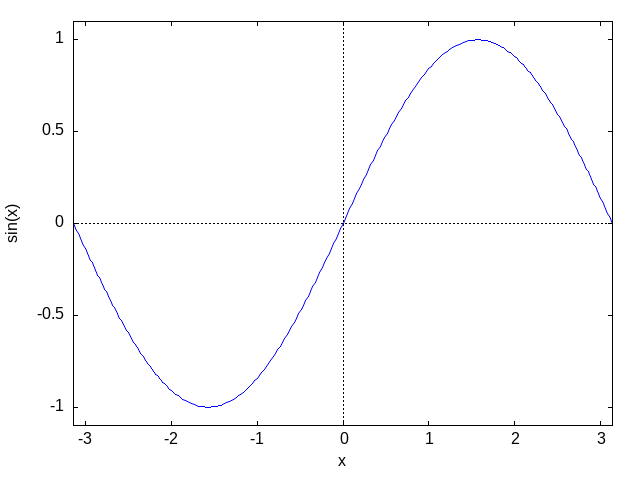

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_10_29T21_17_44_054.png



In [ ]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

In [ ]:
module MaximaMacro

using Base: tempname
using Dates
import Base.display

export @maxima_cell_session, maxima_eval

# -------------------------------------------------
# ¿Es un comando gráfico?
# -------------------------------------------------
function is_plot_command(cmd::String)::Bool
    lower = lowercase(cmd)
    return any(kw -> occursin(kw, lower), ["plot2d", "plot3d", "draw2d", "draw3d", "wxplot"])
end

# -------------------------------------------------
# Evalúa un único comando y devuelve cadena
# -------------------------------------------------
function maxima_eval(cmd::String)::String
    stripped = strip(cmd)
    if !endswith(stripped, ";") && !endswith(stripped, "\$")
        cmd = cmd * ";"
    end

    proc = open(`maxima --quiet`, "r+")
    write(proc.in, "display2d:false\$\n")
    write(proc.in, "linel:32767\$\n")
    write(proc.in, "ignore(load(\"qinf\"))\$\n")
    write(proc.in, cmd * "\n")
    close(proc.in)
    raw = String(read(proc.out))
    wait(proc)

    for line in split(raw, '\n')
        s = strip(line)
        m = match(r"^\s*\(%o4\)\s*(.+)", s)
        if m !== nothing
            return m.captures[1]
        end
    end
    return ""
end

# -------------------------------------------------
# Genera y muestra gráfico en Jupyter + guarda en ./plots/
# -------------------------------------------------

function _maxima_plot_to_jupyter(plot_cmd::String; format="png")
    cmd_clean = strip(replace(plot_cmd, r"[;\$]$" => ""))
    tmpfile = joinpath(pwd(), "maxima_plot_temp.$format")
    macfile = tempname() * ".mac"

    isfile(tmpfile) && rm(tmpfile)

    # Reconstruir comando con opciones integradas
    if endswith(cmd_clean, ")")
        plot_with_opts = cmd_clean[1:end-1] *
                         ", [gnuplot_term, $format], " *
                         "[gnuplot_out_file, \"$(tmpfile)\"])"
    else
        plot_with_opts = cmd_clean
    end

    mac_content = """
    kill(all)\$
    display2d:false\$
    linel:32767\$
    ignore(load("qinf"))\$
    gnuplot_pipes: true\$
    $plot_with_opts\$
    """

    write(macfile, mac_content)

    try
        # ✅ Suprimir salida de Maxima
        run(pipeline(`maxima --quiet --batch=$macfile`, stderr=devnull, stdout=devnull))

        # Espera activa
        max_wait = 2.0
        check_interval = 0.1
        elapsed = 0.0
        file_ready = false
        while elapsed < max_wait
            if isfile(tmpfile) && filesize(tmpfile) > 0
                file_ready = true
                break
            end
            sleep(check_interval)
            elapsed += check_interval
        end

        if !file_ready
            println("❌ No se generó el gráfico.")
            return false
        end

        img_data = read(tmpfile)
        if format == "png"
            display(MIME("image/png"), img_data)
        elseif format == "svg"
            display(MIME("image/svg+xml"), String(img_data))
        end

        plot_dir = joinpath(pwd(), "plots")
        mkpath(plot_dir)
        timestamp = replace(string(now()), r"[:\.\- ]" => "_")
        permanent_path = joinpath(plot_dir, "plot_$(timestamp).$(format)")
        write(permanent_path, img_data)
        println("💾 Gráfico guardado en: $permanent_path")

        return true
    catch e
        println("Error: ", e)
        return false
    finally
        isfile(macfile) && rm(macfile, force=true)
        isfile(tmpfile) && rm(tmpfile, force=true)
    end
end
# -------------------------------------------------
# Macro principal: @maxima_cell_session
# -------------------------------------------------
macro maxima_cell_session(exs...)
    if length(exs) == 0
        error("Se requiere al menos un comando Maxima")
    end

    creditos = false
    cmds_list = Any[exs...]

    # Detectar creditos=true al final
    if length(cmds_list) >= 1
        last_arg = cmds_list[end]
        if last_arg isa Expr && last_arg.head === :(=) &&
           length(last_arg.args) == 2 &&
           last_arg.args[1] == :creditos &&
           last_arg.args[2] == true
            creditos = true
            pop!(cmds_list)
        end
    end

    # Validar y preparar comandos
    user_cmds = String[]
    for ex in cmds_list
        if ex isa String
            cmd = ex
        elseif ex isa Expr && ex.head === :string
            str_repr = sprint(show, ex)
            if length(str_repr) >= 2 && str_repr[1] == '"' && str_repr[end] == '"'
                cmd = str_repr[2:end-1]
            else
                error("Cadena no válida: $ex")
            end
        else
            error("Solo se permiten cadenas literales entre comillas")
        end

        stripped = strip(cmd)
        if !endswith(stripped, ";") && !endswith(stripped, "\$")
            cmd = cmd * ";"
        end
        push!(user_cmds, cmd)
    end

    # Detectar comandos gráficos
    has_plot = any(cmd -> is_plot_command(cmd), user_cmds)

    if has_plot
        # ── Modo híbrido: procesar comandos uno a uno ──
        # Dentro del bloque `if has_plot`
        quote
            if $(creditos)
                println("ℹ️  El modo 'creditos=true' se ignora cuando hay gráficos.")
            end

            cmds = $(user_cmds)
            for (i, cmd) in enumerate(cmds)
                if $(is_plot_command)(cmd)
                    # Mostrar entrada como (%iN) comando;
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    # Mostrar la línea de salida textual
                    println("(%o$(i)) gráfico:")
                    println()  # línea en blanco opcional
                    
                    # Generar y mostrar gráfico (sin mensaje extra)
                    success = $(Symbol("_maxima_plot_to_jupyter"))(cmd)
                    if !success
                        println("(%o$(i)) error al generar gráfico")
                        println()
                    end
                else
                    # Comando no gráfico (sin cambios)
                    res = $(maxima_eval)(cmd)
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    if res != ""
                        println("(%o$(i)) $(res)")
                    end
                    println()
                end
            end
        end
    else
        # ── Modo texto puro ──
        quote
            if $(creditos)
                proc = open(`maxima --disable-readline`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                for line in split(raw_output, '\n')
                    s = strip(line)
                    if s != ""
                        println(line)
                    end
                end
            else
                proc = open(`maxima --quiet`, "r+")
                write(proc.in, "display2d:false\$\n")
                write(proc.in, "linel:32767\$\n")
                write(proc.in, "load(\"qinf\")\$\n")
                for cmd in $(user_cmds)
                    write(proc.in, cmd * "\n")
                end
                close(proc.in)
                raw_output = String(read(proc.out))
                wait(proc)

                results = Dict{Int, String}()
                for line in split(raw_output, '\n')
                    s = strip(line)
                    m = match(r"^\s*\(%o(\d+)\)\s*(.*)", s)
                    if m !== nothing
                        n = parse(Int, m.captures[1])
                        results[n] = line
                    end
                end

                for (i, cmd) in enumerate($(user_cmds))
                    cmd_clean = rstrip(strip(cmd), [';', '\$'])
                    terminator = endswith(strip(cmd), "\$") ? "\$" : ";"
                    println("(%i$(i)) $(cmd_clean)$(terminator)")
                    result_key = i + 3
                    if haskey(results, result_key)
                        fixed_line = replace(results[result_key], "(%o$(result_key))" => "(%o$(i))", count=1)
                        println(fixed_line)
                    end
                    println()
                end
            end
        end
    end
end

end

Main.MaximaMacro

(%i1) integrate(x^2, x);
(%o1) x^3/3

(%i2) float(%pi);
(%o2) 3.141592653589793

(%i3) plot2d(sin(x), [x, -%pi, %pi]);
(%o3) gráfico:



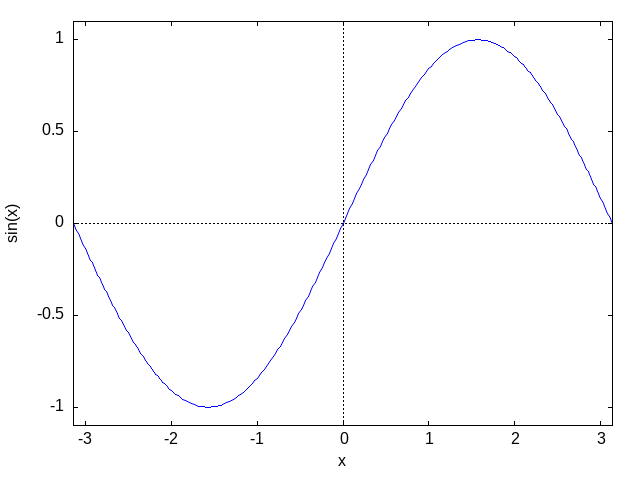

💾 Gráfico guardado en: /home/miguel/pruebasWxmaxima/ejerciciosJulia_PythonMaxima/plots/plot_2025_10_29T21_43_53_538.png


In [ ]:
using .MaximaMacro
# Ejemplo mixto

@maxima_cell_session(
    "integrate(x^2, x)",
    "float(%pi)",
    "plot2d(sin(x), [x, -%pi, %pi])"
)

# Cómo enviar los resultados a un fichero 

Además de que salgan en Jupyter

# Subida a github 

Con la estructura necesaria

# Debug en Julia

https://www.julia-vscode.org/docs/stable/userguide/debugging/#:~:text=Open%20a%20Julia%20file%20in,Julia%20file%20in%20the%20debugger.

# Latex: como hacer para que Markdown interprete latex

**Activar soporte Markdown + LaTeX**

**!!! Seguir indagando en esto !!!**

En las celdas de tipo Markdown de tu notebook, puedes usar sintaxis LaTeX estándar:

Tipo de ecuación -->	       Sintaxis	    -->                 Ejemplo renderizado

En línea	\$ ... \$	-->       \$\alpha + \beta = \gamma\$ -->   𝛼 + 𝛽 = 𝛾

En bloque	\$\$ ... \$\$	

En resumen, basta en línea con encerrar el texto de Latex entre $ y con dobles $$ cuando es un bloque. 
